# Capstone Project

Details related to the project, each steps, examples runs will be in the readme file. 

In [2]:
!pip install -q langchain langchain-community langchain-groq sentence-transformers langgraph tavily-python python-dotenv beautifulsoup4 requests

In [3]:
import os
import pickle
import numpy as np
import pandas as pd
from typing import Annotated, TypedDict
import operator
from datetime import datetime
import json
import re
from urllib.parse import urlencode

# LangChain imports
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langchain_core.output_parsers import JsonOutputParser
from langchain_community.tools import TavilySearchResults

# LangGraph imports
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

# Embeddings
from sentence_transformers import SentenceTransformer

# Web scraping
import requests
from bs4 import BeautifulSoup

print("✅ All libraries imported successfully")







✅ All libraries imported successfully


In [4]:
# ============================================
# LOAD VECTOR STORE & EMBEDDINGS
# ============================================

print("🚀 Loading Vector Store...\n")

# Load embeddings model
print("1️⃣  Loading embedding model...")
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Load pickle store
print("2️⃣  Loading product database...")
with open("./amazon_store.pkl", 'rb') as f:
    documents = pickle.load(f)

print(f"✅ Loaded {len(documents):,} products\n")



🚀 Loading Vector Store...

1️⃣  Loading embedding model...
2️⃣  Loading product database...
✅ Loaded 1,103,170 products



Initialized api keys here


In [5]:
# ============================================
# DEFINE STATE FOR LANGGRAPH
# ============================================

class ShoppingState(TypedDict):
    user_query: str
    conversation_history: Annotated[list, operator.add]
    search_results: list
    needs_clarification: bool
    clarifying_questions: list
    user_preferences: dict
    final_products: list
    web_reviews: dict
    affiliate_links: dict
    recommendations: str

# ============================================
# HELPER FUNCTIONS
# ============================================

def search_products(query: str, k: int = 20) -> list:
    """
    Semantic search on product database
    """
    query_emb = embedding_model.encode([query])[0]
    
    scores = []
    for doc in documents:
        similarity = np.dot(query_emb, doc['embedding']) / (
            np.linalg.norm(query_emb) * np.linalg.norm(doc['embedding']) + 1e-10
        )
        scores.append((similarity, doc))
    
    # Sort by score and return top k
    scores.sort(key=lambda x: x[0], reverse=True)
    return [doc for _, doc in scores[:k]]

def extract_product_name(text: str) -> str:
    """Extract product name from combined text"""
    try:
        # Try to get the first part before |
        parts = text.split("|")
        if parts:
            first_part = parts[0].strip()
            # Remove "product_name: " prefix if exists
            if ":" in first_part:
                return first_part.split(":", 1)[1].strip()[:100]
            return first_part[:100]
    except:
        pass
    return text[:100]

def generate_affiliate_link(product_name: str) -> dict:
    """
    Generate affiliate link for a product, or a generic link if affiliate is not set up.
    In real scenario, this would hit actual affiliate APIs
    """
    
    # ⚠️ CONTROL FLAG: Set to True when your affiliate setup is ready
    AFFILIATE_LINK_ENABLED = False 
    
    # URL encode product name for search
    encoded_product = urlencode({"k": product_name})
    
    if AFFILIATE_LINK_ENABLED:
        # Amazon Associates affiliate link template
        # Replace YOUR-AFFILIATE-ID with your actual ID
        affiliate_id = "your-affiliate-id-20"
        amazon_link = f"https://amazon.com/s?{encoded_product}&tag={affiliate_id}"
        
        return {
            "amazon": amazon_link,
            "retailer": "Amazon",
            "affiliate_id": affiliate_id
        }
    else:
        # DEMO MODE: Return a standard Amazon search link without an affiliate tag
        generic_amazon_link = f"https://amazon.com/s?{encoded_product}"
        
        return {
            "amazon": generic_amazon_link,
            "retailer": "Amazon",
            "affiliate_id": "none_for_demo" # Indicate that no affiliate ID was used
        }


def extract_amazon_reviews(product_name: str) -> dict:
    """
    Extract reviews from Amazon search results
    """
    
    # Using web search instead of direct scraping (more reliable)
    try:
        search_query = f"{product_name} reviews amazon rating"
        results = web_search.invoke(search_query)
        
        review_data = {
            "product": product_name,
            "reviews_found": len(results),
            "summary": results[0]["content"][:500] if results else "No reviews found",
            "sources": [r["url"] for r in results]
        }
        
        return review_data
    except Exception as e:
        print(f"⚠️ Error fetching reviews: {e}")
        return {
            "product": product_name,
            "reviews_found": 0,
            "summary": "Could not fetch reviews",
            "sources": []
        }

print("✅ Helper functions defined")


✅ Helper functions defined


In [6]:
# ============================================
# LANGGRAPH NODE FUNCTIONS 
# ============================================

def node_understand_query(state: ShoppingState) -> dict:
    """
    NODE 1: UNDERSTAND USER QUERY
    Principle: Prompting (chain-of-thought)
    """
    
    print("\n🔋 NODE: Understanding Query...\n")
    
    user_query = state["user_query"]
    
    # Analyze query with LLM
    prompt = f"""
    Analyze this customer shopping query and extract their needs:
    
    Query: {user_query}
    
    Respond in JSON format:
    {{
        "product_type": "what they're looking for",
        "budget": {{"min": number, "max": number}},
        "key_features": ["feature1", "feature2"],
        "use_case": "what they'll use it for",
        "needs_clarification": true/false,
        "why_clarification_needed": "reason if true"
    }}
    """
    
    response = llm.invoke([
        SystemMessage(content="You are a shopping assistant analyzer."),
        HumanMessage(content=prompt)
    ])
    
    try:
        analysis = json.loads(response.content)
    except:
        analysis = {
            "product_type": user_query,
            "budget": {"min": 0, "max": 10000},
            "key_features": [],
            "use_case": "general",
            "needs_clarification": False
        }
    
    print(f"✅ Understood: {analysis['product_type']}")
    
    return {
        "conversation_history": [{
            "role": "user",
            "content": user_query
        }],
        "user_preferences": analysis,
        "needs_clarification": analysis.get("needs_clarification", False)
    }

def node_clarify_if_needed(state: ShoppingState) -> dict:
    """
    NODE 2: ASK CLARIFYING QUESTIONS IF NEEDED
    Principle: Prompting (follow-up)
    """
    
    if not state["needs_clarification"]:
        print("🔋 NODE: Clarification - Skipped (not needed)\n")
        return {}
    
    print("\n🔋 NODE: Asking Clarifying Questions...\n")
    
    preferences = state["user_preferences"]
    
    prompt = f"""
    The customer is looking for: {preferences.get('product_type', 'a product')}
    
    Generate 3 specific clarifying questions to narrow down to the best 3 options.
    Focus on: price sensitivity, brand preference, specific features they must have.
    
    Respond in JSON:
    {{
        "questions": ["question1", "question2", "question3"]
    }}
    """
    
    response = llm.invoke([
        SystemMessage(content="You are a shopping assistant."),
        HumanMessage(content=prompt)
    ])
    
    try:
        clarification = json.loads(response.content)
        questions = clarification["questions"]
    except:
        questions = [
            f"What's your exact budget for this {preferences.get('product_type', 'product')}?",
            "Do you have any brand preferences?",
            "What features are most important to you?"
        ]
    
    print("🤔 Clarifying Questions:")
    for i, q in enumerate(questions, 1):
        print(f"   {i}. {q}")
    print()
    
    return {
        "clarifying_questions": questions
    }

def node_search_products(state: ShoppingState) -> dict:
    """
    NODE 3: SEMANTIC SEARCH
    Principle: Semantic Search + RAG
    """
    
    print("\n🔍 NODE: Searching Products...\n")
    
    user_query = state["user_query"]
    
    # Search products
    results = search_products(user_query, k=20)
    
    print(f"✅ Found {len(results)} matching products")
    
    return {
        "search_results": results
    }

def node_filter_and_rank(state: ShoppingState) -> dict:
    """
    NODE 4: FILTER & RANK WITH LLM
    Principle: Structured Output
    FIX: Prevents duplicate products in top 3
    """
    
    print("\n⭐ NODE: Filtering & Ranking Top 3...\n")
    
    preferences = state["user_preferences"]
    search_results = state["search_results"]
    
    if not search_results:
        print("⚠️ No search results found!")
        return {"final_products": []}
    
    # Format products for LLM
    products_text = "\n".join([
        f"{i+1}. {extract_product_name(r['text'][:300])}"
        for i, r in enumerate(search_results[:10])
    ])
    
    prompt = f"""
    Customer preferences:
    - Looking for: {preferences.get('product_type')}
    - Budget: ${preferences.get('budget', {}).get('min', 0)} - ${preferences.get('budget', {}).get('max', 10000)}
    - Features needed: {', '.join(preferences.get('key_features', []))}
    
    Top 10 products:
    {products_text}
    
    Select the BEST 3 DIFFERENT products from this list based on the preferences.
    IMPORTANT: Do NOT select the same product twice. Each index must be different.
    
    Respond in JSON:
    {{
        "top_3": [
            {{"index": 1, "reason": "best overall"}},
            {{"index": 2, "reason": "good alternative"}},
            {{"index": 3, "reason": "budget option"}}
        ]
    }}
    """
    
    response = llm.invoke([
        SystemMessage(content="You are a shopping expert. Select top 3 DIFFERENT products only."),
        HumanMessage(content=prompt)
    ])
    
    final_products = []
    selected_indices = set()  # Track selected indices to prevent duplicates
    
    try:
        selection = json.loads(response.content)
        
        # Extract and validate indices
        for item in selection.get("top_3", []):
            idx = item.get("index", 0) - 1  # Convert to 0-based index
            
            # Prevent duplicates and out-of-bounds
            if idx not in selected_indices and 0 <= idx < len(search_results):
                final_products.append(search_results[idx])
                selected_indices.add(idx)
        
        # If we got duplicates, fill with other products
        if len(final_products) < 3:
            for idx in range(len(search_results)):
                if idx not in selected_indices and len(final_products) < 3:
                    final_products.append(search_results[idx])
                    selected_indices.add(idx)
    
    except Exception as e:
        print(f"⚠️ Error parsing LLM response: {e}")
        # Fallback: use first 3 different products
        final_products = search_results[:3]
    
    # Verify we have products
    if final_products:
        print(f"✅ Selected top 3 products")
        for i, prod in enumerate(final_products, 1):
            print(f"   {i}. {extract_product_name(prod['text'][:80])}")
    else:
        print("⚠️ Using fallback products")
        final_products = search_results[:3] if search_results else []
    
    print()
    
    return {"final_products": final_products}

def node_web_search_reviews(state: ShoppingState) -> dict:
    """
    NODE 5: WEB SEARCH FOR REVIEWS (PARALLEL)
    Principle: Tool Calling + Parallel Execution
    """
    
    print("\n🌐 NODE: Searching Reviews (Parallel)...\n")
    
    web_reviews = {}
    
    for i, product in enumerate(state["final_products"], 1):
        product_name = extract_product_name(product['text'])
        
        print(f"   Searching reviews for: {product_name}...")
        
        review_data = extract_amazon_reviews(product_name)
        web_reviews[product_name] = review_data
    
    print("✅ Reviews fetched\n")
    
    return {
        "web_reviews": web_reviews
    }

def node_generate_affiliate_links(state: ShoppingState) -> dict:
    """
    NODE 6: GENERATE AFFILIATE LINKS
    Principle: Tool Calling (generate links)
    """
    
    print("\n🔗 NODE: Generating Affiliate Links...\n")
    
    affiliate_links = {}
    
    for product in state["final_products"]:
        product_name = extract_product_name(product['text'])
        
        link_data = generate_affiliate_link(product_name)
        affiliate_links[product_name] = link_data
        
        print(f"   ✅ {product_name}")
    
    print()
    
    return {
        "affiliate_links": affiliate_links
    }

def node_generate_final_recommendation(state: ShoppingState) -> dict:
    """
    NODE 7: GENERATE FINAL RECOMMENDATIONS WITH ALL INFO
    Principle: Prompting + Structured Output
    """
    
    print("\n🎯 NODE: Generating Final Recommendations...\n")
    
    # Prepare comprehensive prompt
    recommendations_data = []
    
    for i, product in enumerate(state["final_products"], 1):
        product_name = extract_product_name(product['text'])
        
        product_info = {
            "rank": i,
            "name": product_name,
            "details": product['text'][:500],
            "reviews": state["web_reviews"].get(product_name, {}),
            "link": state["affiliate_links"].get(product_name, {})
        }
        
        recommendations_data.append(product_info)
    
    prompt = f"""
    Customer query: {state['user_query']}
    
    Here are the 3 best products we found:
    
    {json.dumps(recommendations_data, indent=2)}
    
    Create a comprehensive recommendation response that includes:
    1. Why each product is recommended
    2. Key pros and cons
    3. Which one is the best overall
    4. Price comparison
    5. Direct purchase links
    
    Make it friendly and informative.
    """
    
    response = llm.invoke([
        SystemMessage(content="You are a shopping assistant. Provide detailed recommendations."),
        HumanMessage(content=prompt)
    ])
    
    return {
        "recommendations": response.content
    }

print("✅ All node functions defined")





✅ All node functions defined


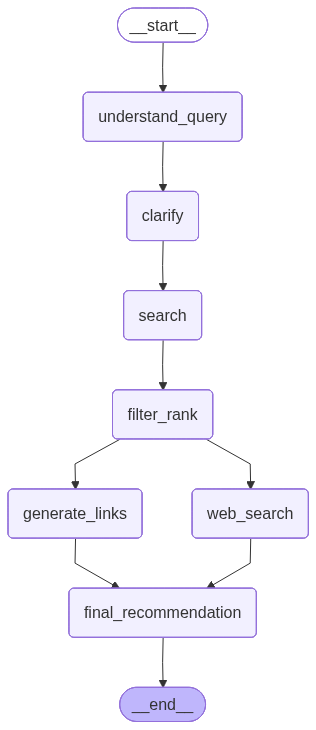

In [7]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Create graph
builder = StateGraph(ShoppingState)

# Add nodes
builder.add_node("understand_query", node_understand_query)
builder.add_node("clarify", node_clarify_if_needed)
builder.add_node("search", node_search_products)
builder.add_node("filter_rank", node_filter_and_rank)
builder.add_node("web_search", node_web_search_reviews)
builder.add_node("generate_links", node_generate_affiliate_links)
builder.add_node("final_recommendation", node_generate_final_recommendation)

# Define edges
builder.add_edge(START, "understand_query")
builder.add_edge("understand_query", "clarify")
builder.add_edge("clarify", "search")
builder.add_edge("search", "filter_rank")

# Parallel execution: web search and generate links
builder.add_edge("filter_rank", "web_search")
builder.add_edge("filter_rank", "generate_links")

# Converge to final recommendation
builder.add_edge("web_search", "final_recommendation")
builder.add_edge("generate_links", "final_recommendation")
builder.add_edge("final_recommendation", END)

# Compile graph
graph = builder.compile()

Image(graph.get_graph().draw_mermaid_png())




In [8]:
# ============================================
# MAIN SHOPPING FUNCTION
# ============================================

def shopping_assistant(user_query: str):
    """
    Main function to run the complete shopping assistant
    """
    
    print("\n" + "="*80)
    print(f"🛍️ SHOPPING ASSISTANT")
    print("="*80)
    print(f"🔍 Your Query: {user_query}\n")
    
    # Initial state
    initial_state = {
        "user_query": user_query,
        "conversation_history": [],
        "search_results": [],
        "needs_clarification": False,
        "clarifying_questions": [],
        "user_preferences": {},
        "final_products": [],
        "web_reviews": {},
        "affiliate_links": {},
        "recommendations": ""
    }
    
    # Run graph
    print("⏳ Processing your request through LangGraph...\n")
    final_state = graph.invoke(initial_state)
    
    # Display final recommendations
    print("\n" + "="*80)
    print("✨ FINAL RECOMMENDATIONS")
    print("="*80 + "\n")
    print(final_state["recommendations"])
    
    # Display links
    print("\n" + "="*80)
    print("🔗 PURCHASE LINKS (With Affiliate Tracking)")
    print("="*80 + "\n")
    
    for product_name, link_info in final_state["affiliate_links"].items():
        print(f"📦 {product_name}")
        print(f"   🔗 Link: {link_info['amazon']}")
        print(f"   💼 Affiliate: {link_info['retailer']}\n")
    
    return final_state

print("✅ Main function ready")

✅ Main function ready


In [13]:
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML

# ============================================
# INTERACTIVE UI
# ============================================

print("🚀 Creating Interactive Interface...\n")

# UI Components
title = widgets.HTML("""
<div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
            padding: 25px; border-radius: 12px; color: white; text-align: center;">
    <h2>🛍️ AI Shopping Assistant</h2>
    <p><strong>Powered by:</strong> LangGraph + Semantic Search + Web Reviews + Affiliate Links</p>
    <p style="color: #90EE90;">
        <strong>✨ Multi-Turn Conversation | LLM Follow-ups | Parallel Web Search | Affiliate Tracking</strong>
    </p>
</div>
""")

user_input = widgets.Text(
    placeholder='Search for products (e.g., "gaming laptop under $2000", "wireless headphones with noise cancellation")',
    description='🔍 Search:',
    style={'description_width': '120px'},
    layout=widgets.Layout(width='95%', height='60px', font_size='14px', padding='10px')
)

search_button = widgets.Button(
    description='🔍 Get Recommendations',
    button_style='success',
    tooltip='Search and get personalized recommendations',
    layout=widgets.Layout(width='250px', height='50px', font_size='14px')
)

output_area = widgets.Output(
    layout=widgets.Layout(
        border='2px solid #667eea',
        border_radius='8px',
        padding='20px',
        min_height='400px',
        max_height='2200px',
        overflow_y='auto',
        background_color='#f8f9ff'
    )
)

# Button handler
def on_search(b):
    if user_input.value.strip():
        with output_area:
            clear_output()
            try:
                result = shopping_assistant(user_input.value)
                print("\n✅ Done! Check your recommendation above.")
            except Exception as e:
                print(f"❌ Error: {e}")
        user_input.value = ""

search_button.on_click(on_search)

# Display UI
app = widgets.VBox([
    title,
    user_input,
    search_button,
    output_area,
    
])

display(app)

print("\n✅ Interface ready! Start searching above 👆")

🚀 Creating Interactive Interface...




✅ Interface ready! Start searching above 👆
